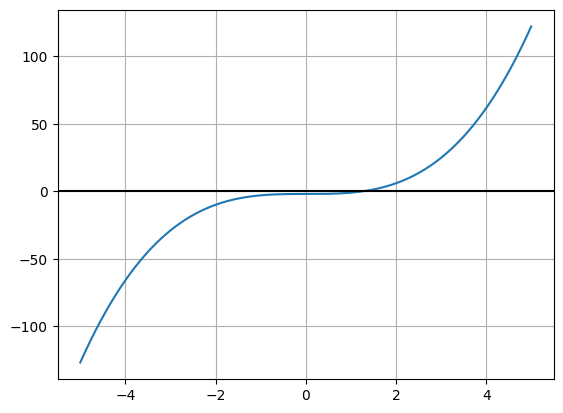

In [269]:
from abc import ABC,abstractmethod
import matplotlib.pyplot as plt
import numpy as np

class functionClass(ABC):
  """ here to define the function f and its derivative and maybe the g transformation that will be used"""
  @abstractmethod
  def function(self,x):
    pass

  @abstractmethod
  def derivative(self,x):
    pass

  @abstractmethod
  def g_transform(self,x):
    """ implement when you need to use the fixed point methods """
    pass

  def df(f,x):
    h = 0.001
    return (f(x+h) - f(x)) / h

  def plot(self,interval: list[int]):
    y = [self.function(x) for x in interval]
    plt.plot(interval, y)
    plt.axhline(0,color="black",linewidth=1.5)
    plt.grid()
    plt.show()


class squared(functionClass):

  def function(self,x):
    return x ** 3 - 2

  def derivative(self,x):
    return 3 * x ** 2

  def g_transform(self,x):
    pass
f = squared()
f.plot(np.arange(-5,5,0.01))

In [278]:
import warnings

class ConditionNotVerifiedError(Exception):
  pass

def plot_line_2_points(point1,point2,color="green",linestyle="-",alpha=0.9):
  x_values = [point1[0],point2[0]]
  y_values = [point1[1],point2[1]]
  plt.plot(x_values,y_values,color=color,linestyle=linestyle,alpha=alpha)


class Algorithms:

  def bisection_method(f,a,b,epsilon,plot = False,nmax=1000):
    """solving f(x) = 0 with the bisection method ( like a binary search ) with the condition:
      f(a)*f(b) >= 0
    """
    if f(a)*f(b) >= 0:
      raise ConditionNotVerifiedError("Bisection method fails f(a)*f(b) >= 0")

    niter = 1
    r = (a + b) / 2

    if plot:
      interval = np.arange(a,b,0.01)
      while (f(r) != 0) and ((b - a) / 2 >= epsilon) and (niter <= nmax) :
        if f(r) * f(a) > 0:
          a = r
        else:
          b = r
        niter +=1
        r = (a + b) / 2

      plt.plot(interval,[f(x) for x in interval],label="f(x)")
      plt.scatter([r],[f(r)],marker="x",color="red")
      plt.axhline(0,color="black",linewidth=1.1)
      plt.title(f"f(x) = 0 with niter= {niter}")
      plt.text(r+0.01,f(r)+0.04,f"({r:.4}, {f(r):.4})")
      plt.legend()
      plt.grid()
      plt.show()
    else:
      while (f(r) != 0) and ((b - a) / 2 >= epsilon) and (niter <= nmax) :
        if f(r) * f(a) > 0:
          a = r
        else:
          b = r
        niter +=1
        r = (a + b) / 2


    if (niter > nmax):
      warnings.warn("number of iteration reached its maximum")
    if f(r) == 0:
      print("== FOUND EXACT ROOT ==")
      return r,niter
    if (b - a) / 2 < epsilon:
      return r,niter

  def fixed_point_iteration(g,r0:int,epsilon:int,a: int,b: int,plot: bool= False,nmax = 1000,f= None):
    """ solving the equation g(x) = x,
        where the user must have checked that the sequence converges,
        the function will return root, number of iterations and the estimated error if max|g'(x)|= K < 1 (if not: K=2)
        if plot= True, the cobweb diagrma will be plotted
     """
    if not (r0 >= a and r0 <= b):
      raise ConditionNotVerifiedError("r0 must be in the interval [a,b]")

    interval = np.arange(a,b,0.01)
    derivative_values = [abs(functionClass.df(g,x)) for x in interval]
    K = max(derivative_values)
    if K >= 1:
      warnings.warn("Fixed point iteration might fails K >= 1")
      K=2
    niter = 0
    r = g(r0)

    diff = abs(r - r0)
    try:
      if plot:
        while abs(r - r0) >= epsilon and niter < nmax:
          r0 = r
          r = g(r0)
          niter +=1

        err = (K ** niter / (1 - K)) * diff
        if not f is None:
          plt.plot(interval, [f(x) for x in interval],color="red",label="f(x)")
          plt.axhline(0,color="black",linewidth=1.1)
        plt.plot(interval, [g(x) for x in interval],color="blue",label="g(x)")
        plt.plot(interval,interval,color="black",label="x",alpha=0.5)
        plot_line_2_points([r,0],[r,r])
        plt.text(r+0.01,f(r)+0.04,f"({r:.4}, {f(r):.4})")
        plt.title("f(x) = 0 with g(x) = x method")
        plt.legend()
        plt.grid()
        plt.show()

      else:
        while abs(r - r0) >= epsilon and niter <= nmax:
          r0 = r
          r = g(r0)
          niter +=1
        err = (K ** niter / (1 - K)) * diff

      if niter >= nmax:
        warnings.warn("number of iteration reached its maximum")
    except OverflowError as e:
      raise OverflowError("Fixed point iteration is DIVERGING")
    return r,niter,err

  def newton_method(f,df,r0: int | None,epsilon,a,b,plot: bool=False,nmax = 1000):
    """ special case of the fixed point method with the conditions:
        -f(a)*f(b) >= 0
        -f(x) <> 0 for all x in [a,b]
        -f'(x) <> 0 for all x in [a,b]
    """
    interval = np.arange(a,b,0.01)
    def d2f(x):
      h = 0.001
      return (df(x+h) - df(x)) / h

    if (f(a)*f(b) >= 0):
      raise ConditionNotVerifiedError("Newton method fails f(a)*f(b) >= 0")
    elif (0 in [df(x) for x in interval]) or (0 in [d2f(x) for x in interval]):
      warnings.warn("there is f'(x) = 0 or f''(x) = 0 check you calculations in the interval")

    if r0 is None:
      if abs(df(a)) < abs(df(b)):
        c = a
      else :
        c = b
      if abs(f(c) / df(c)) <= b-a:
        r0 = (b + a) / 2 # convergence hold for any r0 in [a,b]
      else:
        for i in interval:
          if f(i)*d2f(i) > 0 :
            r0 = i
            break
    else:
        if not (r0 >= a and r0 <= b):
          raise ConditionNotVerifiedError("r0 must be in the interval [a,b]")

    def g(x):
      return x - (f(x) / df(x))

    try:
      if plot:
        niter = 0
        r = g(r0)
        while abs(r - r0) >= epsilon and niter <= nmax:
          r0 = r
          r = g(r0)
          niter +=1

        plt.plot(interval, [f(x) for x in interval],color="blue",label="f(x)")
        plt.legend()
        plt.grid()
        plt.axhline(0,color="black",linewidth=1.5)
        if 0 in interval:
          plt.axvline(0,color="black",linewidth=1.2)
        plt.scatter([r],[f(r)],marker="x",color="red")
        plt.title(f"f(x) = 0 with newton method, with niter= {niter}")
        plt.text(r+0.01,f(r)+0.03,f"{r:.3}, {f(r):.3}")
        plt.show()

      else:
        r,niter,_ = Algorithms.fixed_point_iteration(g,r0,epsilon,a,b,False,nmax)
    except OverflowError as e:
      raise OverflowError("Newton method is DIVERGING")

    return r,niter

  def secant_method(f,r0,r1,epsilon,a,b,plot = False,nmax = 1000):
    """ special case of the fixed point method where derivative is not known with the condition:
        f'(r) <> 0 and f(r) = 0
     """
    if (r0 < a or r0 > b) or (r1 < a or r1 > b):
      raise ConditionNotVerifiedError("r0 and r1 must be in the interval [a,b]")

    niter = 0
    if plot :
      interval = np.arange(a,b,0.01)
      while abs(f(r1) - f(r0)) >= epsilon and niter <= nmax:
        r2 = r1 - ((r1 - r0) / (f(r1) - f(r0))) * f(r1)
        r0 = r1
        r1 = r2
        niter +=1

      plt.plot(interval, [f(x) for x in interval],color="blue",label="f(x)")
      plt.axhline(0,color="black",linewidth=1.5)
      if 0 in interval:
        plt.axvline(0,color="black",linewidth=1.2)
      plt.scatter([r2],[f(r2)],marker="x",color="red")
      plt.title(f"f(x) = 0 with secant method with niter= {niter}")
      plt.text(r2+0.01,f(r2)+0.03,f"{r2:.3}, {f(r2):.3}")
      plt.legend()
      plt.grid()
      plt.show()
    else:
      while abs(f(r1) - f(r0)) >= epsilon and niter <= nmax:
        r2 = r1 - ((r1 - r0) / (f(r1) - f(r0))) * f(r1)
        r0 = r1
        r1 = r2
        niter +=1

    if niter >= nmax:
      warnings.warn("number of iteration reached its maximum")
    return r2,niter
    pass

========== TESTING WITH FUNCTION f(x) = X^2 - 2 ============


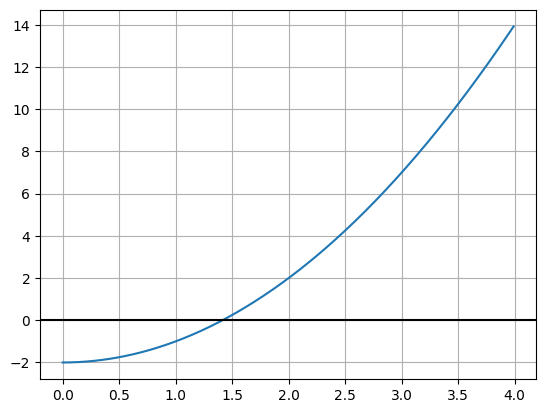

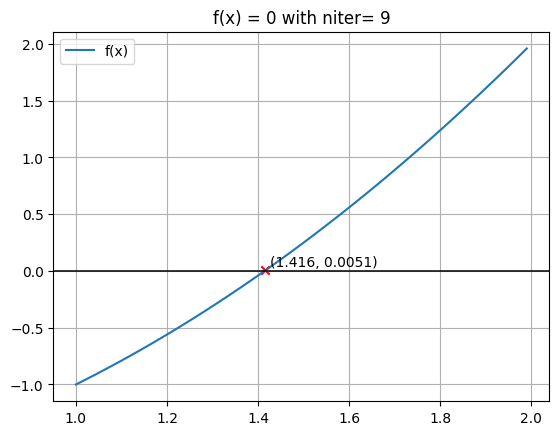

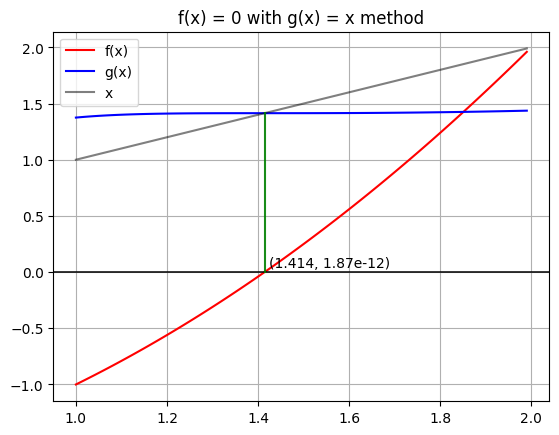

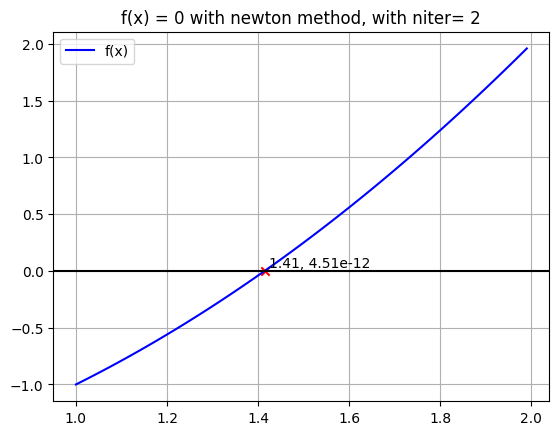

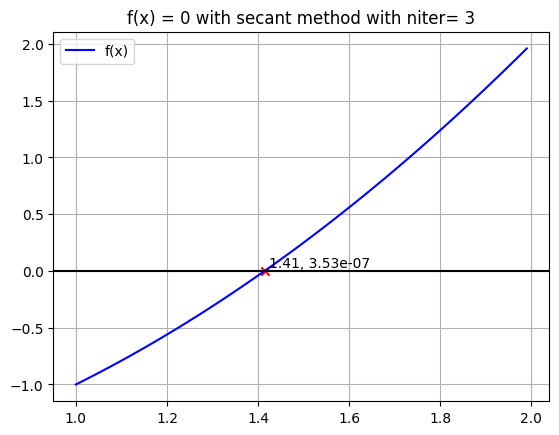

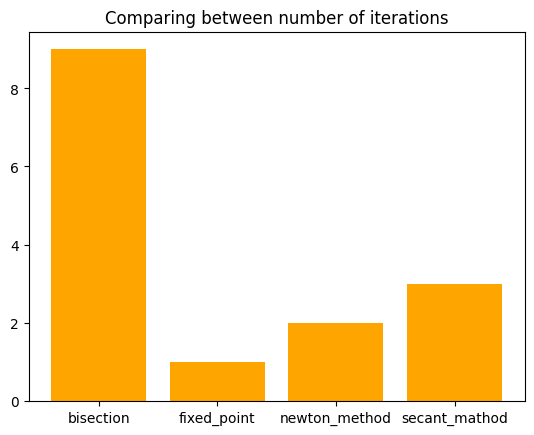


========== TESTING WITH FUNCTION f(X) = e^x -x - 2 ============



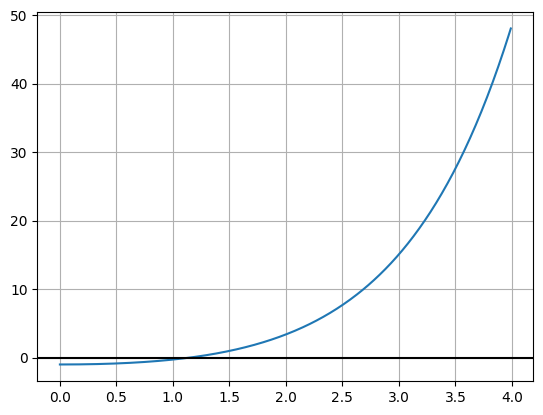

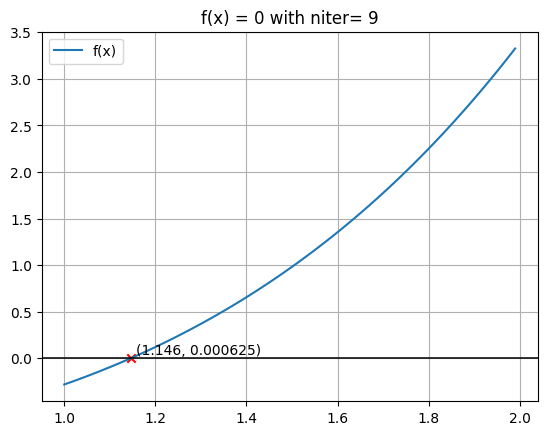

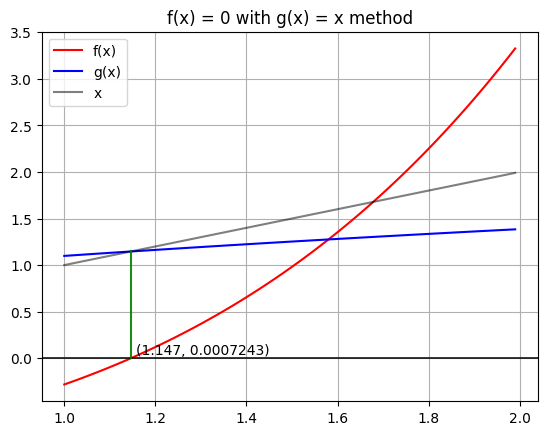

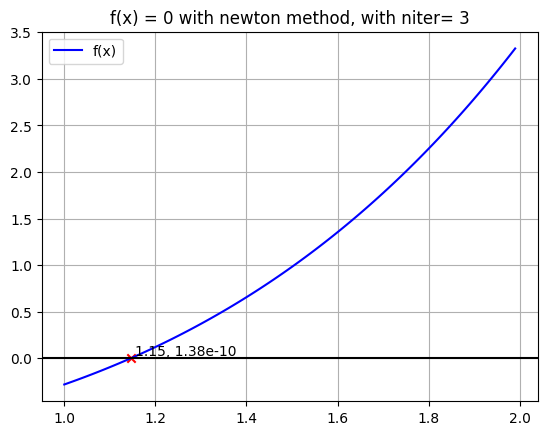

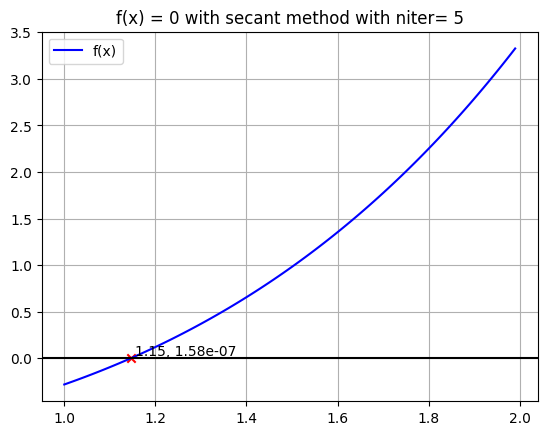

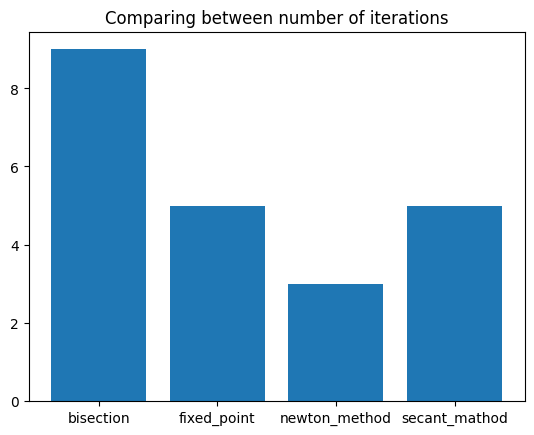

========== TESTING WITH FUNCTION f(X) = cos(x) - x ============


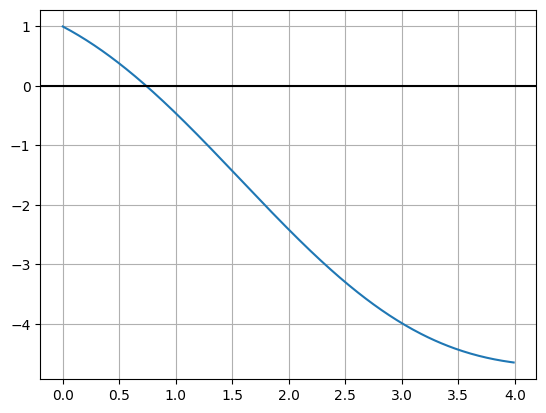

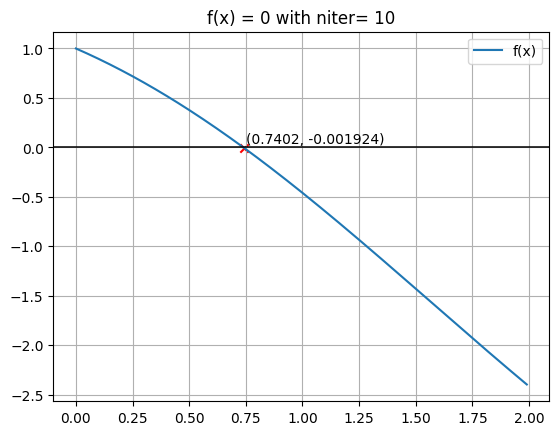

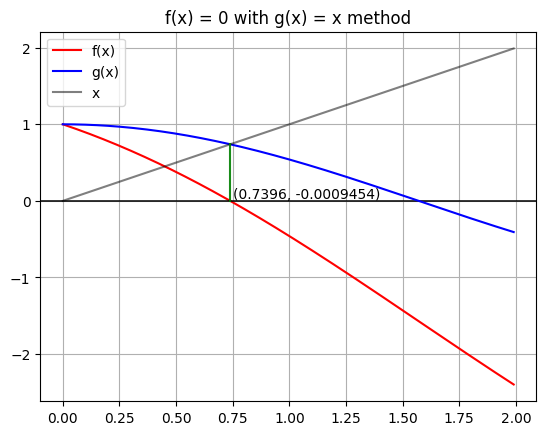

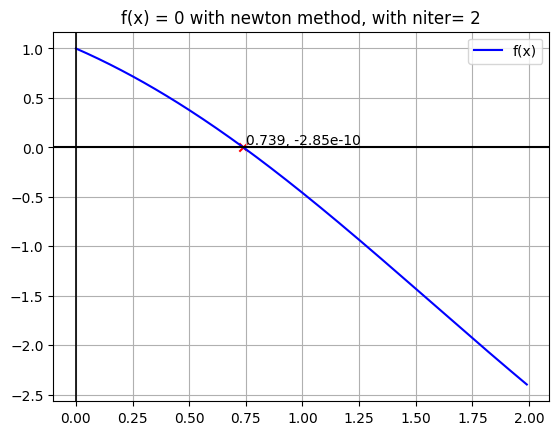

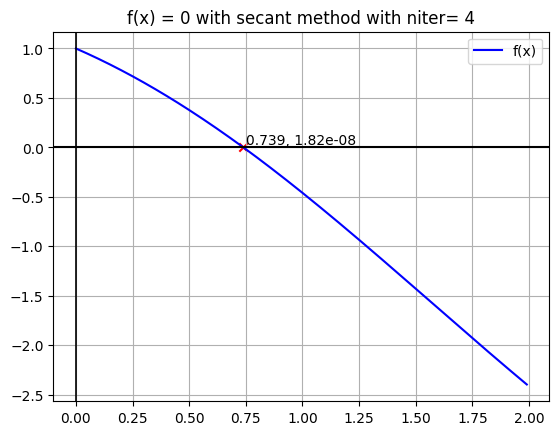

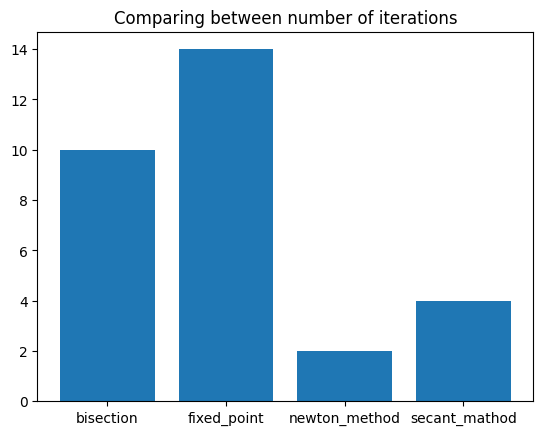

In [281]:
from logging import root
from math import e,log

class test1(functionClass):
  def function(self,x):
    return x ** 2 - 2
  def derivative(sef,x):
    return 2 * x
  def g_transform(self, x):
    return (3/8)*x + (3/(2*x)) - (1/(2*(x**3)))

class test2(functionClass):
  def function(self,x):
    return e ** x -x -2
  def derivative(sef,x):
    return e ** x -1
  def g_transform(self, x):
    return log(x+2)

class test3(functionClass):
  def function(self,x):
    return np.cos(x) - x
  def derivative(sef,x):
    return -np.sin(x) - 1
  def g_transform(self, x):
    return np.cos(x)

nitervalues = {
    "bisection" : 0,
    "fixed_point": 0,
    "newton_method": 0,
    "secant_mathod": 0,
}
f = test1()
print("========== TESTING WITH FUNCTION f(x) = X^2 - 2 ============")
f.plot(np.arange(0,4,0.01))
root,niter = Algorithms.bisection_method(f.function,1,2,0.002,True)
nitervalues["bisection"] = niter

root,niter,err = Algorithms.fixed_point_iteration(f.g_transform,1.5,0.002,1,2,True,f=f.function)
nitervalues["fixed_point"] = niter

root,niter = Algorithms.newton_method(f.function,f.derivative,None,0.002,1,2,True)
nitervalues["newton_method"] = niter

root,niter = Algorithms.secant_method(f.function,1.4,1.8,0.002,1,2,True)
nitervalues["secant_mathod"] = niter

plt.bar(x=nitervalues.keys(),height=nitervalues.values(),color="orange")
plt.title("Comparing between number of iterations")
plt.show()


f = test2()
print("\n========== TESTING WITH FUNCTION f(X) = e^x -x - 2 ============\n")
f.plot(np.arange(0,4,0.01))
root,niter = Algorithms.bisection_method(f.function,1,2,0.002,True)
nitervalues["bisection"] = niter

root,niter,err = Algorithms.fixed_point_iteration(f.g_transform,1.5,0.002,1,2,True,f=f.function)
nitervalues["fixed_point"] = niter

root,niter = Algorithms.newton_method(f.function,f.derivative,None,0.002,1,2,True)
nitervalues["newton_method"] = niter

root,niter = Algorithms.secant_method(f.function,1.4,1.8,0.002,1,2,True)
nitervalues["secant_mathod"] = niter

plt.bar(x=nitervalues.keys(),height=nitervalues.values(),color="orange")
plt.title("Comparing between number of iterations")
plt.show()


f = test3()
print("========== TESTING WITH FUNCTION f(X) = cos(x) - x ============")
f.plot(np.arange(0,4,0.01))
root,niter = Algorithms.bisection_method(f.function,0,2,0.002,True)
nitervalues["bisection"] = niter

root,niter,err = Algorithms.fixed_point_iteration(f.g_transform,0.5,0.002,0,2,True,f=f.function)
nitervalues["fixed_point"] = niter

root,niter = Algorithms.newton_method(f.function,f.derivative,None,0.002,0,2,True)
nitervalues["newton_method"] = niter

root,niter = Algorithms.secant_method(f.function,0.4,1.2,0.002,0,2,True)
nitervalues["secant_mathod"] = niter

plt.bar(x=nitervalues.keys(),height=nitervalues.values(),color="orange")
plt.title("Comparing between number of iterations")
plt.show()

